#### Library import

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [29]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [30]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [31]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14509335039722784249
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14347490451813791941
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [32]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [71]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [72]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [73]:
As = data
Cd = data
Ni = data

In [74]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

#### Oversampling by SMOGN (SMOTE Regression)

In [75]:
import smogn

In [76]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 158.65it/s]


In [89]:
As_smogn = As_smogn.reset_index(drop = True)
Cd_smogn = Cd_smogn.reset_index(drop = True)
Ni_smogn = Ni_smogn.reset_index(drop = True)

#### Eliminate outlier and train / test split

In [90]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [91]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [92]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [93]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [94]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1863, 15)
(1967, 15)
(2120, 15)


StandardScaler

In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [ ]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [96]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1490, 15)
(1573, 15)
(1696, 15)


#### 10-Fold Crossvalidation

In [46]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [97]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [98]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [99]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 02:04:43,619] A new study created in memory with name: svm_parameter_opt
[I 2023-08-29 02:04:45,647] Trial 0 finished with value: 0.2705176723694742 and parameters: {'C': 94.63144068943551, 'epsilon': 0.09704353060876614, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.2705176723694742.
[I 2023-08-29 02:04:45,811] Trial 1 finished with value: 0.35157362649186874 and parameters: {'C': 0.511738517327365, 'epsilon': 0.7158001836457631, 'kernel': 'rbf', 'degree': 4}. Best is trial 1 with value: 0.35157362649186874.
[I 2023-08-29 02:04:46,869] Trial 2 finished with value: 0.20207923682676704 and parameters: {'C': 4.5109865968604534, 'epsilon': 0.5618784066246875, 'kernel': 'linear', 'degree': 5}. Best is trial 1 with value: 0.35157362649186874.
[I 2023-08-29 02:04:51,270] Trial 3 finished with value: 0.19270567088230667 and parameters: {'C': 10.710728186498914, 'epsilon': 0.013369908266705055, 'kernel': 'linear', 'degree': 4}. Best is trial 1 with value: 0.3515736

Best r2:  0.46959820578474354
Best trial: {'C': 6.001437713347997, 'epsilon': 0.18240136592398828, 'kernel': 'rbf', 'degree': 5}


In [100]:
optuna.visualization.plot_parallel_coordinate(study)

In [101]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 6.001437713347997, 'epsilon': 0.18240136592398828, 'kernel': 'rbf', 'degree': 5}


In [102]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=6.001437713347997, degree=5, epsilon=0.18240136592398828)

In [103]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [ ]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [104]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.43269689612639384
Test RMSE:  0.594110027768976


In [105]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6653073712342545
Test R2:  0.4640175868904526


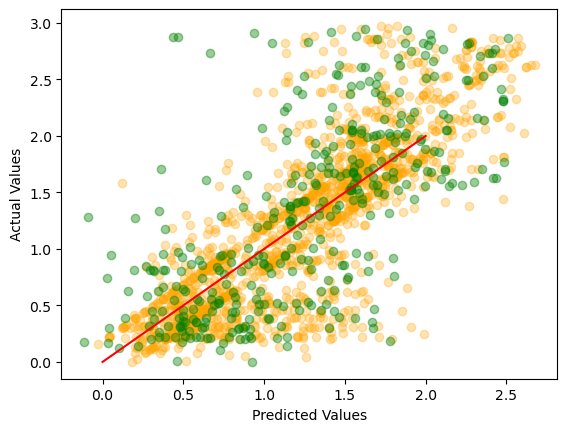

In [106]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

In [114]:
As_pred = pd.DataFrame(y_train_pred, columns = ['As_pred'])
As_pred_test = pd.DataFrame(y_test_pred, columns = ['As_pred'])

In [109]:
As_y_train = As_y_train.reset_index(drop = False)
As_y_test = As_y_test.reset_index(drop = False)

In [110]:
As_data = pd.concat([As_pred, As_y_train], axis = 1)
As_data_test = pd.concat([As_pred_test, As_y_test], axis = 1)

In [111]:
As_data.to_csv('SVM_As_data.csv', sep = ',')
As_data_test.to_csv('SVM_As_test_data.csv', sep = ',')

Cd

Optimization

In [119]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 02:26:23,015] A new study created in memory with name: svm_parameter_opt
[I 2023-08-29 02:26:23,028] Trial 0 finished with value: -0.7121605581077811 and parameters: {'C': 0.5314705666949262, 'epsilon': 0.5644815645864951, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -0.7121605581077811.
[I 2023-08-29 02:26:23,478] Trial 1 finished with value: 0.4846030534482312 and parameters: {'C': 0.135196021043594, 'epsilon': 0.05144365347098477, 'kernel': 'rbf', 'degree': 4}. Best is trial 1 with value: 0.4846030534482312.
[I 2023-08-29 02:26:24,884] Trial 2 finished with value: 0.4517846632114151 and parameters: {'C': 32.634355795937566, 'epsilon': 0.07004805577039606, 'kernel': 'rbf', 'degree': 1}. Best is trial 1 with value: 0.4846030534482312.
[I 2023-08-29 02:26:24,895] Trial 3 finished with value: -0.7121605581077811 and parameters: {'C': 15.829578099617224, 'epsilon': 0.5062762144295885, 'kernel': 'linear', 'degree': 1}. Best is trial 1 with value: 0.48460305344

Best r2:  0.5444739921628287
Best trial: {'C': 3.1429214334491236, 'epsilon': 0.0744934490876871, 'kernel': 'rbf', 'degree': 3}


In [120]:
optuna.visualization.plot_parallel_coordinate(study)

In [121]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 3.1429214334491236, 'epsilon': 0.0744934490876871, 'kernel': 'rbf', 'degree': 3}


In [122]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=3.1429214334491236, epsilon=0.0744934490876871)

In [123]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [124]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.13484222489276873
Test RMSE:  0.18563387702945786


In [125]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.7034925726832537
Test R2:  0.4894454614462673


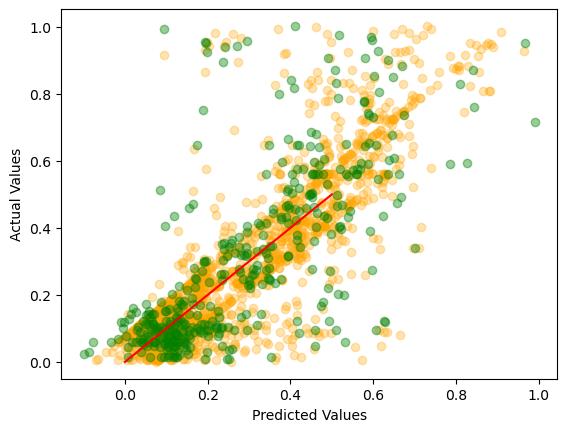

In [126]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

In [127]:
Cd_pred = pd.DataFrame(y_train_pred, columns = ['Cd_pred'])
Cd_pred_test = pd.DataFrame(y_test_pred, columns = ['Cd_pred'])

In [128]:
Cd_y_train = Cd_y_train.reset_index(drop = False)
Cd_y_test = Cd_y_test.reset_index(drop = False)

In [129]:
Cd_data = pd.concat([Cd_pred, Cd_y_train], axis = 1)
Cd_data_test = pd.concat([Cd_pred_test, Cd_y_test], axis = 1)

In [130]:
Cd_data.to_csv('SVM_Cd_data.csv', sep = ',')
Cd_data_test.to_csv('SVM_Cd_test_data.csv', sep = ',')

Ni

In [131]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-29 02:37:05,340] A new study created in memory with name: svm_parameter_opt
[I 2023-08-29 02:37:06,426] Trial 0 finished with value: -0.5229652187384541 and parameters: {'C': 6.788129411643938, 'epsilon': 0.07624634715823703, 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: -0.5229652187384541.
[I 2023-08-29 02:37:07,800] Trial 1 finished with value: -19.834159898815262 and parameters: {'C': 5.439177863698125, 'epsilon': 0.050486679935578926, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.5229652187384541.
[I 2023-08-29 02:37:08,754] Trial 2 finished with value: -43.03246657122715 and parameters: {'C': 2.970733848914296, 'epsilon': 0.033766222805683956, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.5229652187384541.
[I 2023-08-29 02:37:09,372] Trial 3 finished with value: 0.34424745722960476 and parameters: {'C': 0.2396852356479776, 'epsilon': 0.1035673231626175, 'kernel': 'rbf', 'degree': 4}. Best is trial 3 with value: 0.34424745

Best r2:  0.5895210315946482
Best trial: {'C': 18.886460992870358, 'epsilon': 0.46310608928603536, 'kernel': 'rbf', 'degree': 3}


In [132]:
optuna.visualization.plot_parallel_coordinate(study)

In [133]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 18.886460992870358, 'epsilon': 0.46310608928603536, 'kernel': 'rbf', 'degree': 3}


In [134]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=18.886460992870358, epsilon=0.46310608928603536)

In [135]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [136]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.5940052705336718
Test RMSE:  0.8308353165792369


In [137]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.7640724378016233
Test R2:  0.5200465707586495


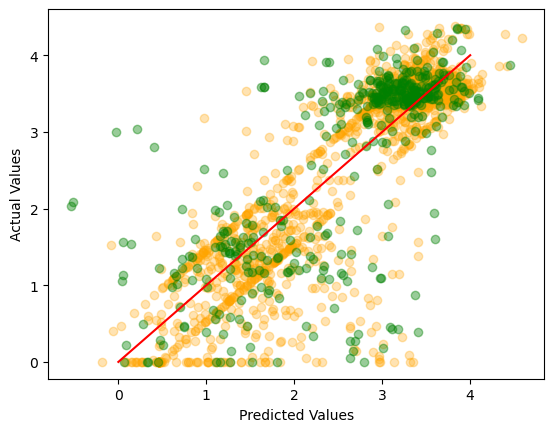

In [138]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

In [139]:
Ni_pred = pd.DataFrame(y_train_pred, columns = ['Ni_pred'])
Ni_pred_test = pd.DataFrame(y_test_pred, columns = ['Ni_pred'])

In [140]:
Ni_y_train = Ni_y_train.reset_index(drop = False)
Ni_y_test = Ni_y_test.reset_index(drop = False)

In [141]:
Ni_data = pd.concat([Ni_pred, Ni_y_train], axis = 1)
Ni_data_test = pd.concat([Ni_pred_test, Ni_y_test], axis = 1)

In [142]:
Ni_data.to_csv('SVM_Ni_train_data.csv', sep = ',')
Ni_data_test.to_csv('SVM_Ni_test_data.csv', sep = ',')